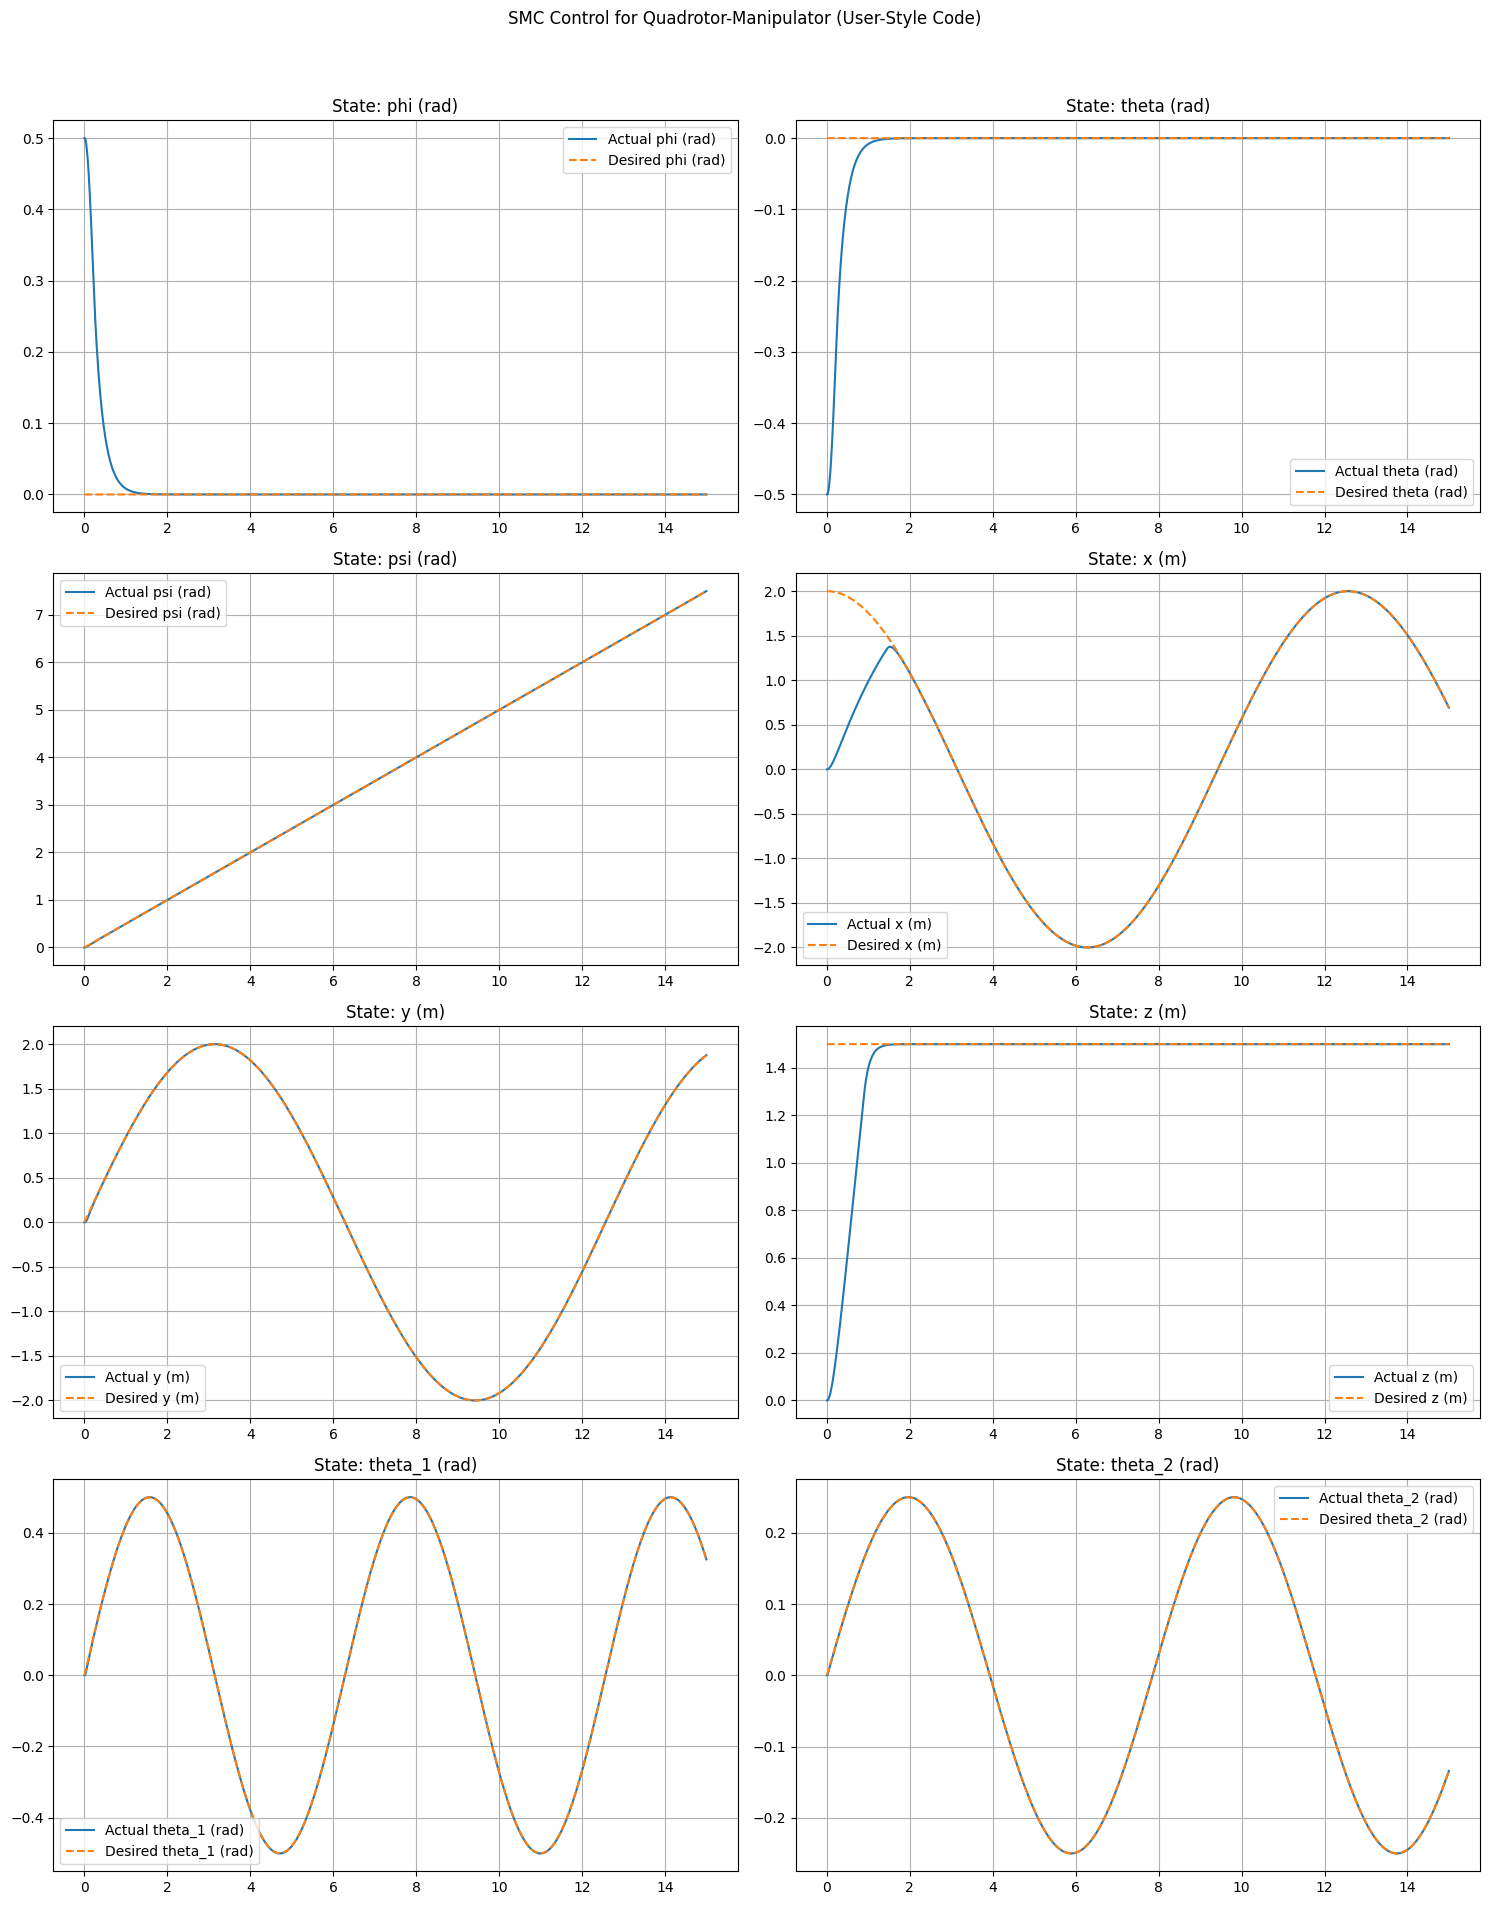

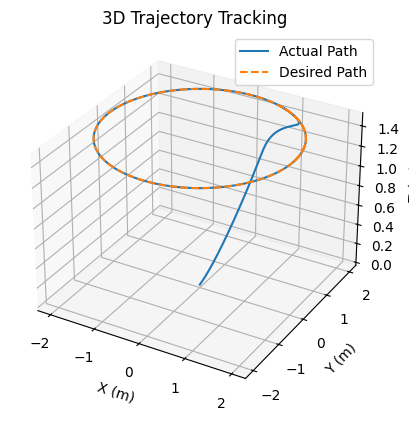

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# 1. Initialization and Parameter Definition
# ==============================================================================
dt = 0.01  # Smaller time step for better stability
t = np.arange(0, 15 + dt, dt)
n = len(t)

# Desired Trajectory - Circular Path
radius = 2.0
angular_freq = 0.5
height = 1.5

# Desired Positions
x_d = radius * np.cos(angular_freq * t)
y_d = radius * np.sin(angular_freq * t)
z_d = np.full(n, height)
phi_d = np.zeros(n)
theta_d = np.zeros(n)
psi_d = angular_freq * t
theta1_d = 0.5 * np.sin(t)
theta2_d = 0.25 * np.sin(0.8 * t)

# Desired Velocities (Trajectory Derivative)
dx_d = -radius * angular_freq * np.sin(angular_freq * t)
dy_d = radius * angular_freq * np.cos(angular_freq * t)
dz_d = np.zeros(n)
dphi_d = np.zeros(n)
dtheta_d = np.zeros(n)
dpsi_d = np.full(n, angular_freq)
dtheta1_d = 0.5 * np.cos(t)
dtheta2_d = 0.25 * 0.8 * np.cos(0.8 * t)

# State Variable Definitions (16 states)
x1, x2 = np.zeros(n), np.zeros(n)       # phi, dphi
x3, x4 = np.zeros(n), np.zeros(n)       # theta, dtheta
x5, x6 = np.zeros(n), np.zeros(n)       # psi, dpsi
x7, x8 = np.zeros(n), np.zeros(n)       # x, dx
x9, x10 = np.zeros(n), np.zeros(n)      # y, dy
x11, x12 = np.zeros(n), np.zeros(n)     # z, dz
x13, x14 = np.zeros(n), np.zeros(n)     # theta1, dtheta1
x15, x16 = np.zeros(n), np.zeros(n)     # theta2, dtheta2

# Initial Conditions
x1[0] = 0.5
x3[0] = -0.5
x11[0] = 0  # Initial height

# Control Inputs (6 inputs)
u1, u2, u3, u4 = np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n)
u5, u6 = np.zeros(n), np.zeros(n)
omega_r = np.zeros(n)  # Assumed zero for simplicity

# Physical System Parameters (from the paper)
g = 9.81
m = 1.0
Ixx = 12.522e-3
Iyy = 13.215e-3
Izz = 23.527e-3
I_r = 0  # Assumed zero for simplicity

# Manipulator Arm Parameters (Approximated)
M1, M2 = 0.01, 0.01

# Dynamic Coefficients
a1 = (Iyy - Izz) / Ixx
a3 = (Izz - Ixx) / Iyy
a5 = (Ixx - Iyy) / Izz
b1, b2, b3 = 1 / Ixx, 1 / Iyy, 1 / Izz

# SMC Hyperparameters (Combined gains as approved)
landa = np.array([4.5, 4.5, 6.0, 7.0, 9.0, 9.0, 8.0, 8.0])
k = np.array([12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 16.0, 16.8])
epsilon = 0.1  # For the saturation function

# ==============================================================================
# 2. Main Simulation and Control Loop
# ==============================================================================
for i in range(n - 1):
    # Interaction terms from the arm (assumed zero for code execution)
    F_m_q = np.zeros(3)  # [F_m_q_x, F_m_q_y, F_m_q_z]
    M_m_q = np.zeros(3)  # [M_m_q_phi, M_m_q_theta, M_m_q_psi]
    N_arm = np.zeros(2)  # [N1, N2]

    # Define sliding surfaces for each state
    s_phi = (dphi_d[i] - x2[i]) + landa[0] * (phi_d[i] - x1[i])
    s_theta = (dtheta_d[i] - x4[i]) + landa[1] * (theta_d[i] - x3[i])
    s_psi = (dpsi_d[i] - x6[i]) + landa[2] * (psi_d[i] - x5[i])
    s_z = (dz_d[i] - x12[i]) + landa[3] * (z_d[i] - x11[i])
    s_x = (dx_d[i] - x8[i]) + landa[4] * (x_d[i] - x7[i])
    s_y = (dy_d[i] - x10[i]) + landa[5] * (y_d[i] - x9[i])
    s_theta1 = (dtheta1_d[i] - x14[i]) + landa[6] * (theta1_d[i] - x13[i])
    s_theta2 = (dtheta2_d[i] - x16[i]) + landa[7] * (theta2_d[i] - x15[i])

    # --- Control Law Calculation (u1 to u6) ---
    # Desired virtual accelerations for x and y (used directly in dynamics simulation)
    ax_d = k[4] * np.tanh(s_x / epsilon) + landa[4] * (dx_d[i] - x8[i])
    ay_d = k[5] * np.tanh(s_y / epsilon) + landa[5] * (dy_d[i] - x10[i])

    # Calculate u1 (Thrust) based on Z-altitude control
    u1[i+1] = (m / (np.cos(x1[i]) * np.cos(x3[i]))) * (g + landa[3] * (dz_d[i] - x12[i]) + k[3] * np.tanh(s_z / epsilon) - F_m_q[2]/m)
    if u1[i+1] < 0: u1[i+1] = 0  # Thrust cannot be negative

    # Calculate body torques u2, u3, u4
    u2[i+1] = (1/b1) * (landa[0]*(dphi_d[i]-x2[i]) + k[0]*np.tanh(s_phi/epsilon) - a1*x4[i]*x6[i] - M_m_q[0]/Ixx)
    u3[i+1] = (1/b2) * (landa[1]*(dtheta_d[i]-x4[i]) + k[1]*np.tanh(s_theta/epsilon) - a3*x2[i]*x6[i] - M_m_q[1]/Iyy)
    u4[i+1] = (1/b3) * (landa[2]*(dpsi_d[i]-x6[i]) + k[2]*np.tanh(s_psi/epsilon) - a5*x4[i]*x2[i] - M_m_q[2]/Izz)

    # Calculate arm torques u5, u6
    u5[i+1] = M1 * (landa[6]*(dtheta1_d[i]-x14[i]) + k[6]*np.tanh(s_theta1/epsilon)) - N_arm[0]
    u6[i+1] = M2 * (landa[7]*(dtheta2_d[i]-x16[i]) + k[7]*np.tanh(s_theta2/epsilon)) - N_arm[1]

    # --- System State Update (Euler Integration) ---
    c_phi, s_phi = np.cos(x1[i]), np.sin(x1[i])
    c_theta, s_theta = np.cos(x3[i]), np.sin(x3[i])
    c_psi, s_psi = np.cos(x5[i]), np.sin(x5[i])

    # Rotational accelerations (based on paper's dynamics)
    dx2 = a1*x4[i]*x6[i] - I_r/Ixx * x4[i]*omega_r[i] + b1*u2[i+1] + M_m_q[0]/Ixx
    dx4 = a3*x2[i]*x6[i] + I_r/Iyy * x2[i]*omega_r[i] + b2*u3[i+1] + M_m_q[1]/Iyy
    dx6 = a5*x2[i]*x4[i] + b3*u4[i+1] + M_m_q[2]/Izz

    # Linear accelerations (using the calculated virtual accelerations)
    dx8 = ax_d
    dx10 = ay_d
    dx12 = (u1[i+1] / m) * (c_theta * c_phi) - g + F_m_q[2]/m

    # Arm accelerations
    dx14 = (u5[i+1] + N_arm[0]) / M1
    dx16 = (u6[i+1] + N_arm[1]) / M2

    # Integration
    x1[i+1], x2[i+1] = x1[i] + dt*x2[i], x2[i] + dt*dx2
    x3[i+1], x4[i+1] = x3[i] + dt*x4[i], x4[i] + dt*dx4
    x5[i+1], x6[i+1] = x5[i] + dt*x6[i], x6[i] + dt*dx6
    x7[i+1], x8[i+1] = x7[i] + dt*x8[i], x8[i] + dt*dx8
    x9[i+1], x10[i+1] = x9[i] + dt*x10[i], x10[i] + dt*dx10
    x11[i+1], x12[i+1] = x11[i] + dt*x12[i], x12[i] + dt*dx12
    x13[i+1], x14[i+1] = x13[i] + dt*x14[i], x14[i] + dt*dx14
    x15[i+1], x16[i+1] = x15[i] + dt*x16[i], x16[i] + dt*dx16

# ==============================================================================
# 3. Plotting Results
# ==============================================================================
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('SMC Control for Quadrotor-Manipulator (User-Style Code)')
labels = ['phi (rad)', 'theta (rad)', 'psi (rad)', 'x (m)', 'y (m)', 'z (m)', 'theta_1 (rad)', 'theta_2 (rad)']
actual_states = [x1, x3, x5, x7, x9, x11, x13, x15]
desired_states = [phi_d, theta_d, psi_d, x_d, y_d, z_d, theta1_d, theta2_d]

for i, ax in enumerate(axs.flat):
    ax.plot(t, actual_states[i], label=f'Actual {labels[i]}')
    ax.plot(t, desired_states[i], '--', label=f'Desired {labels[i]}')
    ax.set_title(f'State: {labels[i]}')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Plot 3D path
fig3d = plt.figure()
ax3d = fig3d.add_subplot(111, projection='3d')
ax3d.plot(x7, x9, x11, label='Actual Path')
ax3d.plot(x_d, y_d, z_d, '--', label='Desired Path')
ax3d.set_xlabel('X (m)'); ax3d.set_ylabel('Y (m)'); ax3d.set_zlabel('Z (m)')
ax3d.set_title('3D Trajectory Tracking'); ax3d.legend(); plt.show()